In [31]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()
access_key_id = os.getenv("ACCESS_KEY_ID")
secret_access_key = os.getenv("SECRET_ACCESS_KEY")
minio_url = "http://" + os.getenv("S3_API_ENDPOINT")


minio_client = boto3.client(
    "s3",
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    endpoint_url=minio_url
)

new_bucket = "trusted-zone"
try:
    minio_client.create_bucket(Bucket=new_bucket)
except (minio_client.exceptions.BucketAlreadyExists, minio_client.exceptions.BucketAlreadyOwnedByYou):
    print(f"Bucket '{new_bucket}' already exists")

Bucket 'trusted-zone' already exists


In [32]:
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import pandas as pd

def analisi_imagen(img):
    
    img = Image.open(BytesIO(img))
    modo = img.mode
    width, height = img.size
    
    #---- CHECK DIMENSIONS & ASPECT RATIO ----
    aspect_ratio = width / height if height > 0 else 0
    total_pixels = width * height
    is_square = abs(aspect_ratio - 1.0) < 0.05
    is_portrait = aspect_ratio < 0.8
    is_landscape = aspect_ratio > 1.2
    
    #---- CHECK BRIGTH AND CONTRAST ----
    image_np = np.array(img)
    brillo = np.mean(image_np)
    contraste = np.std(image_np)
    
    fosca = False
    brillant = False
    contrast = False
    
    if brillo < 80:
        fosca = True
    elif brillo > 200:
        brillant = True
    
    if contraste < 10:
        contrast = True
    
    #---- CHECK COLOR SATURATION ----
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    saturation = np.std(cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)[:, :, 1])
    low_saturation = saturation < 30
    high_saturation = saturation > 100
        
    #---- CHECK SHARPNESS ----
    necessita_nitidez = False
    variance = cv2.Laplacian(cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY), cv2.CV_64F).var()
    if variance < 50:
        necessita_nitidez = True
    
    #---- CHECK BLUR ----
    blur_score = variance
    blur_detected = variance < 50
    
    #---- CHECK NOISE ----
    noise = ""
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    diff = cv2.absdiff(gray, blur)
    local_variance = np.var(diff)
    
    if local_variance < 50:
        noise = 'Low'
    elif local_variance < 150:
        noise = 'Medium'
    else:
        noise = 'High'
    
    #---- CHECK COLOR CHANNELS ----
    has_color = (modo == 'RGB' or modo == 'RGBA')
    num_channels = len(modo)
    
    #---- COMPRESSION ARTIFACTS DETECTION ----
    compression_score = cv2.Laplacian(gray, cv2.CV_64F).var()
    compression_artifacts = compression_score < 20
    
    #---- QUALITY SCORE (Composite) ----
    quality_score = 100
    if fosca or brillant:
        quality_score -= 20
    if contrast:
        quality_score -= 15
    if necessita_nitidez:
        quality_score -= 15
    if noise == 'High':
        quality_score -= 10
    if total_pixels < 10000:  # Very small images
        quality_score -= 20
    
    return{
        'width': width,
        'height': height,
        'aspect_ratio': aspect_ratio,
        'total_pixels': total_pixels,
        'is_square': is_square,
        'is_portrait': is_portrait,
        'is_landscape': is_landscape,
        'brillo': brillo,
        'contraste': contraste,
        'saturation': saturation,
        'low_saturation': low_saturation,
        'high_saturation': high_saturation,
        'fosc': fosca,
        'brillant': brillant,
        'contrast': contrast,
        'nitidez': necessita_nitidez,
        'blur_score': blur_score,
        'blur_detected': blur_detected,
        'noise': noise,
        'has_color': has_color,
        'num_channels': num_channels,
        'compression_artifacts': compression_artifacts,
        'quality_score': quality_score
    }

**analisi_image()**: Imports the required libraries (OpenCV for image processing, PIL for image handling, NumPy for numerical operations, Pandas for data management) and defines the analisi_image() function, which performs a comprehensive image quality analysis.

### **Dimensions and Geometry**
- **`width` and `height`**: Measure the image size in pixels. Very small values may indicate low-resolution images.
- **`total_pixels`**: Product of width × height. Indicates the total resolution of the image.
- **`aspect_ratio`**: Ratio between width and height (width/height). 
  - `ratio ≈ 1.0` → Square image
  - `ratio < 1.0` → Vertical image (portrait)
  - `ratio > 1.0` → Horizontal image (landscape)
- **`is_square`, `is_portrait`, `is_landscape`**: Classify the image orientation.

### **Brightness and Contrast**
- **`brillo`**: Average pixel intensity (0-255). Indicates how light or dark the image is.
  - `< 80`: Dark image
  - `> 200`: Very bright image
- **`contraste`**: Standard deviation of pixels. Measures the difference between light and dark areas.
  - `< 10`: Very low contrast, "flat" image

### **Color Saturation**
- **`saturation`**: Color intensity (from HSV saturation channel). Indicates how "vivid" the colors are.
  - `< 30`: Low saturation, muted colors/grayscale
  - `> 100`: High saturation, very intense colors
- **`low_saturation` / `high_saturation`**: Automatic saturation classification.

### **Sharpness and Blur**
- **`blur_score`**: Uses the Laplacian operator to detect edges. High values = sharp image.
  - `< 50`: Blurred or out-of-focus image
- **`nitidez` and `blur_detected`**: Boolean indicators of whether the image needs improvement.

### **Noise**
- **`noise`**: Detects visual noise by comparing the original image with a blurred version.
  - Low: Little variation, clean image
  - Medium: Moderate variation
  - High: Much noise, "grainy" image

### **Color Channels**
- **`has_color`**: Indicates if the image has color (RGB) or is grayscale.
- **`num_channels`**: Number of channels (1=grayscale, 3=RGB, 4=RGBA).

### **Compression Artifacts**
- **`compression_artifacts`**: Detects degradation from excessive compression (blocks, loss of detail).

### **Quality Score**
- **`quality_score`**: Composite score of 0-100 that penalizes:
  - Very dark or bright images (-20)
  - Low contrast (-15)
  - Lack of sharpness (-15)
  - High noise (-10)
  - Very low resolution (-20)


In [33]:
from tqdm import tqdm
analysis = []

paginator = minio_client.get_paginator("list_objects_v2")

for page in paginator.paginate(Bucket="formatted-zone", Prefix="images/"):
    for obj in tqdm(page.get("Contents", []), desc="Processant imatges"):
        key = obj["Key"]
        filename = key.split("/")[-1]
        
        #---- READ IMAGE ----
        response = minio_client.get_object(Bucket="formatted-zone", Key=key)
        image_data = response["Body"].read()
        
        #---- ANALYSIS ----
        analysis.append(analisi_imagen(image_data))
        
        
df= pd.DataFrame(analysis)
df.head()

Processant imatges: 100%|██████████| 100/100 [00:01<00:00, 76.10it/s]


,width,height,aspect_ratio,total_pixels,is_square,is_portrait,is_landscape,brillo,contraste,saturation,...,brillant,contrast,nitidez,blur_score,blur_detected,noise,has_color,num_channels,compression_artifacts,quality_score
0,600,450,1.333333,270000,False,False,True,145.665296,54.337392,17.053657,...,False,False,True,18.724160,True,Low,True,3,True,85
1,600,450,1.333333,270000,False,False,True,137.392637,53.723028,35.180305,...,False,False,False,87.872644,False,Low,True,3,False,100
2,600,450,1.333333,270000,False,False,True,157.089916,33.828299,26.900083,...,False,False,True,36.492096,True,Low,True,3,False,85
3,600,450,1.333333,270000,False,False,True,151.094652,38.624146,35.107390,...,False,False,True,14.253052,True,Low,True,3,True,85
4,600,450,1.333333,270000,False,False,True,183.518785,51.499751,34.861930,...,False,False,True,16.505489,True,Low,True,3,True,85


In this case, we can observe that the images do not have consistent formats, and some may even require specific processing. For this reason, the trusted zone is an area of critical importance, as it allows us to apply transformations to our objects or elements in order to obtain a more suitable and homogeneous format.

After applying these transformations, the resulting values should fall within the defined tolerance ranges or established quality parameters.

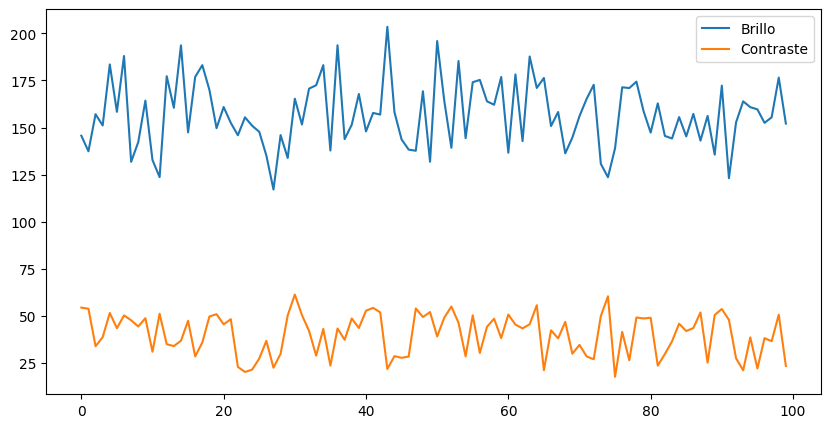

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Select the first two files
# we select two random

plt.figure(figsize=(10, 5))
plt.plot(df['brillo'], label='Brillo')
plt.plot(df['contraste'], label='Contraste')
plt.legend()
plt.show()


In this graph, we can observe non-homogeneous values across the different images. This inconsistency may pose a problem in later stages, such as the exploitation layer, where the embeddings are generated.

Therefore, it is important to apply proper data preprocessing to ensure that brightness and contrast values are as consistent as possible across all images.

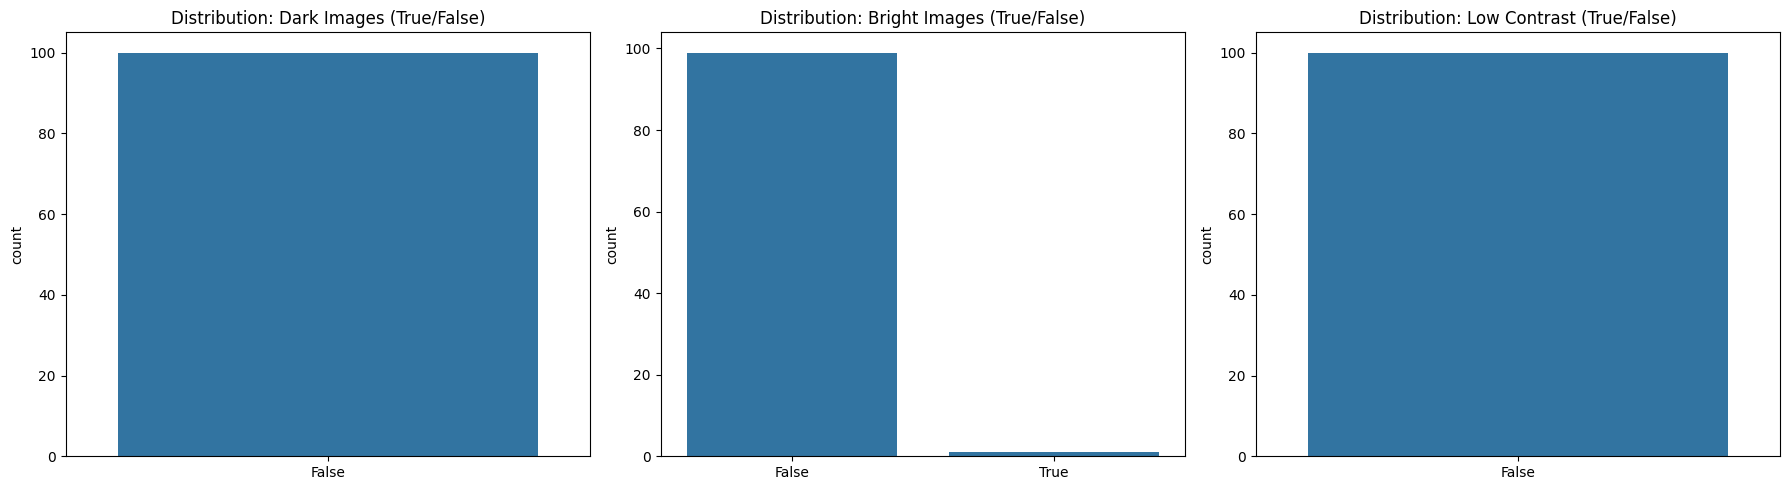

In [35]:
# Otra opción usando Seaborn para visualización categórica
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GRAFIC FOR THE FOSC VALUE (DARKNESS)
df_temp = df.copy()
df_temp['fosc'] = df_temp['fosc'].astype(str)
sns.countplot(data=df_temp, x='fosc', ax=axes[0])
axes[0].set_title('Distribution: Dark Images (True/False)')
axes[0].set_xlabel('')

# GRAFIC FOR THE BRIGHT VALUE (BRIGHTNESS)
df_temp['brillant'] = df_temp['brillant'].astype(str)
sns.countplot(data=df_temp, x='brillant', ax=axes[1])
axes[1].set_title('Distribution: Bright Images (True/False)')
axes[1].set_xlabel('')

# GRAFIC FOR THE CONTRAST VALUE (CONTRAST)
df_temp['contrast'] = df_temp['contrast'].astype(str)
sns.countplot(data=df_temp, x='contrast', ax=axes[2])
axes[2].set_title('Distribution: Low Contrast (True/False)')
axes[2].set_xlabel('')

plt.tight_layout()
plt.show()


The analysis shows that most images exhibit adequate clarity, as they are not excessively dark. Nevertheless, the overall brightness levels remain below the desired range.

While avoiding dark imagery is beneficial, insufficient brightness can also impact visual quality. Maintaining brightness at an intermediate level would ensure images that are both visually clear and properly illuminated.

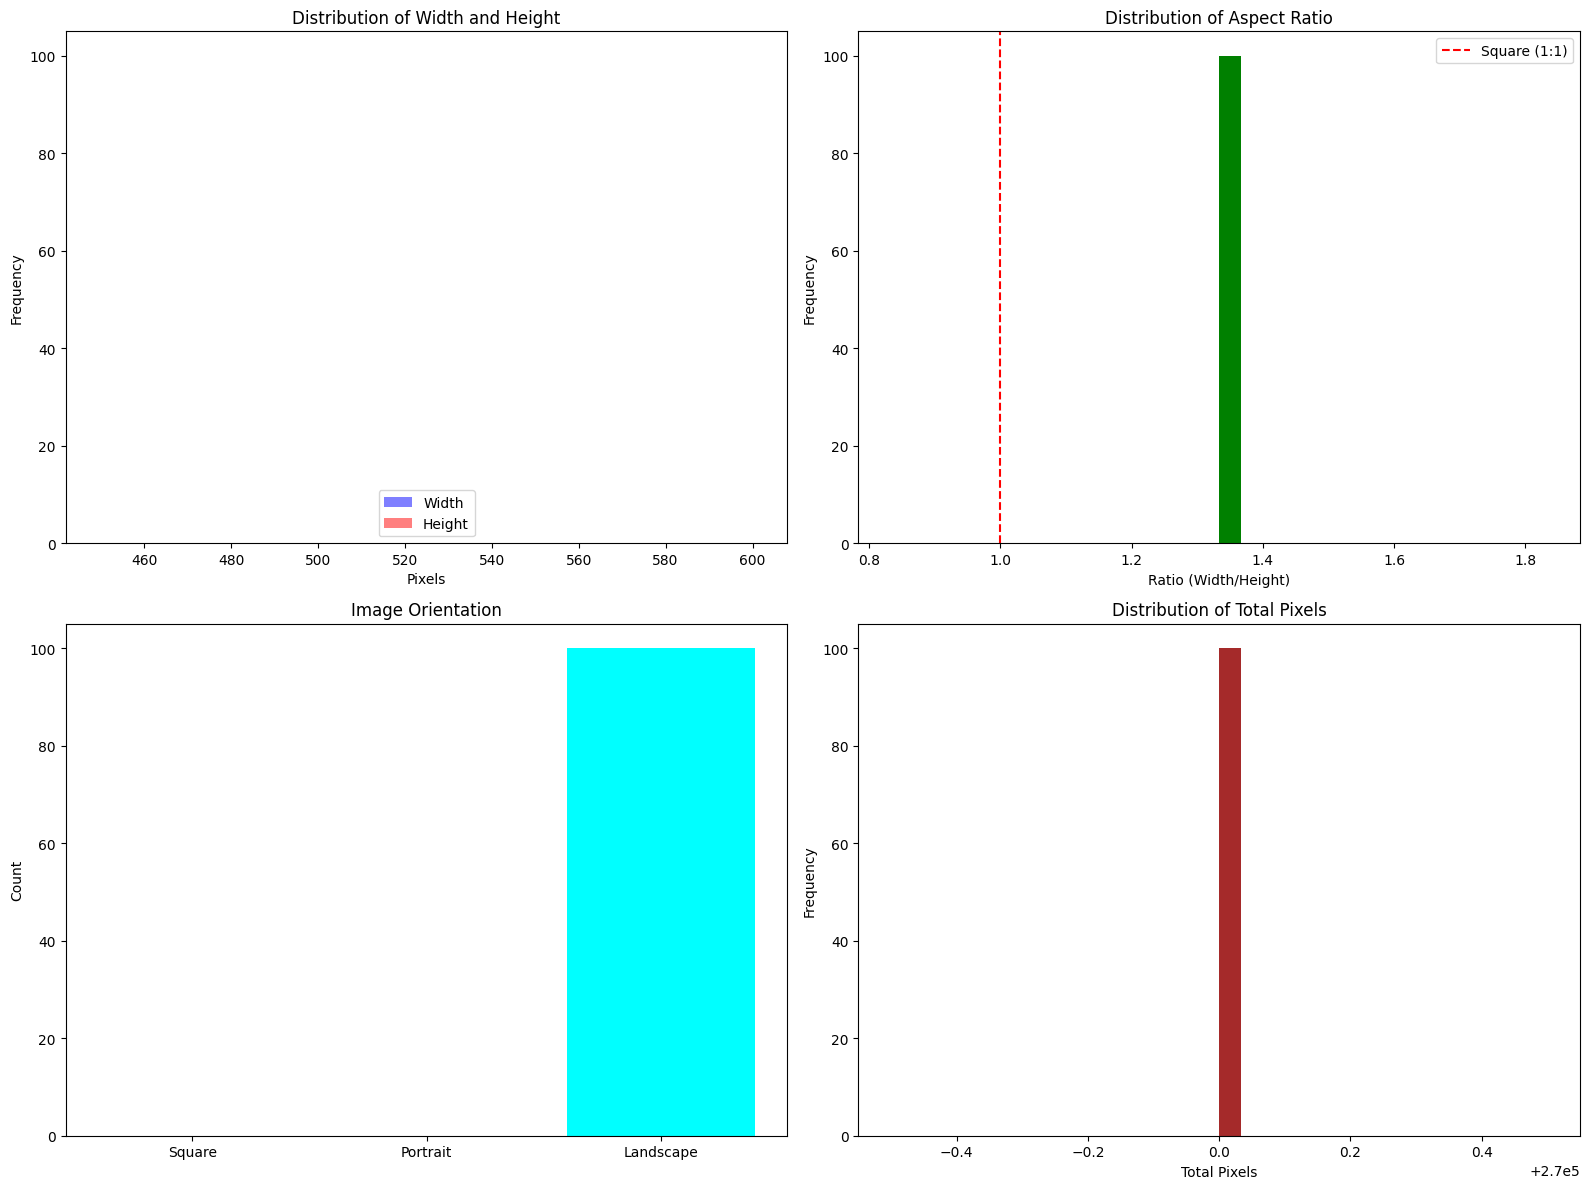

In [36]:
# DIMENSION AND ASPECT RATIO ANALYSIS
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Width and height distribution
axes[0, 0].hist(df['width'], bins=20, alpha=0.5, label='Width', color='blue')
axes[0, 0].hist(df['height'], bins=20, alpha=0.5, label='Height', color='red')
axes[0, 0].set_title('Distribution of Width and Height')
axes[0, 0].set_xlabel('Pixels')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Aspect Ratio
axes[0, 1].hist(df['aspect_ratio'], bins=30, color='green')
axes[0, 1].set_title('Distribution of Aspect Ratio')
axes[0, 1].set_xlabel('Ratio (Width/Height)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(x=1.0, color='red', linestyle='--', label='Square (1:1)')
axes[0, 1].legend()

# Image orientation
orientation_counts = pd.DataFrame({
    'Type': ['Square', 'Portrait', 'Landscape'],
    'Count': [
        df['is_square'].sum(),
        df['is_portrait'].sum(),
        df['is_landscape'].sum()
    ]
})
axes[1, 0].bar(orientation_counts['Type'], orientation_counts['Count'], color=['orange', 'purple', 'cyan'])
axes[1, 0].set_title('Image Orientation')
axes[1, 0].set_ylabel('Count')

# Total pixels
axes[1, 1].hist(df['total_pixels'], bins=30, color='brown')
axes[1, 1].set_title('Distribution of Total Pixels')
axes[1, 1].set_xlabel('Total Pixels')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### **What These Dimension Charts Are Looking For**

This analysis evaluates the **geometric consistency** of our image collection:

1. **Width/Height Distribution**: The overlapping histograms show whether our images have consistent dimensions. Overlapping bars centered around similar values indicate homogeneity, good for uniform processing. Widely scattered distributions suggest our dataset contains images of varying sizes, which may require resizing for consistency. Very narrow peaks mean all images are the same size, ideal for batch processing.

2. **Aspect Ratio Distribution**: This histogram reveals the geometric proportions of our images. A concentration around 1.0 means most images are square (perfect for Instagram-style content). Ratios below 1.0 indicate portrait orientation (taller than wide), while ratios above 1.0 show landscape orientation. A wide spread across different ratios suggests our dataset contains diverse image types that might need normalization. The red dashed line marks the 1:1 square ratio.

3. **Orientation Bar Chart**: This quickly shows the dominant image orientation in our collection. If one type overwhelmingly dominates (e.g., 90% landscape), you have a consistent dataset. An even distribution suggests diversity but may require orientation standardization. Use this to decide whether to crop/normalize images to a single orientation for our application.

4. **Total Pixels Distribution**: This histogram detects image resolution. Images with very low pixel counts (<50,000) may be too small for effective embedding generation. Peaks above 1,000,000 pixels suggest high-resolution images that might need downsampling. A consistent pixel count across all images indicates uniform resolution, optimal for neural network processing.

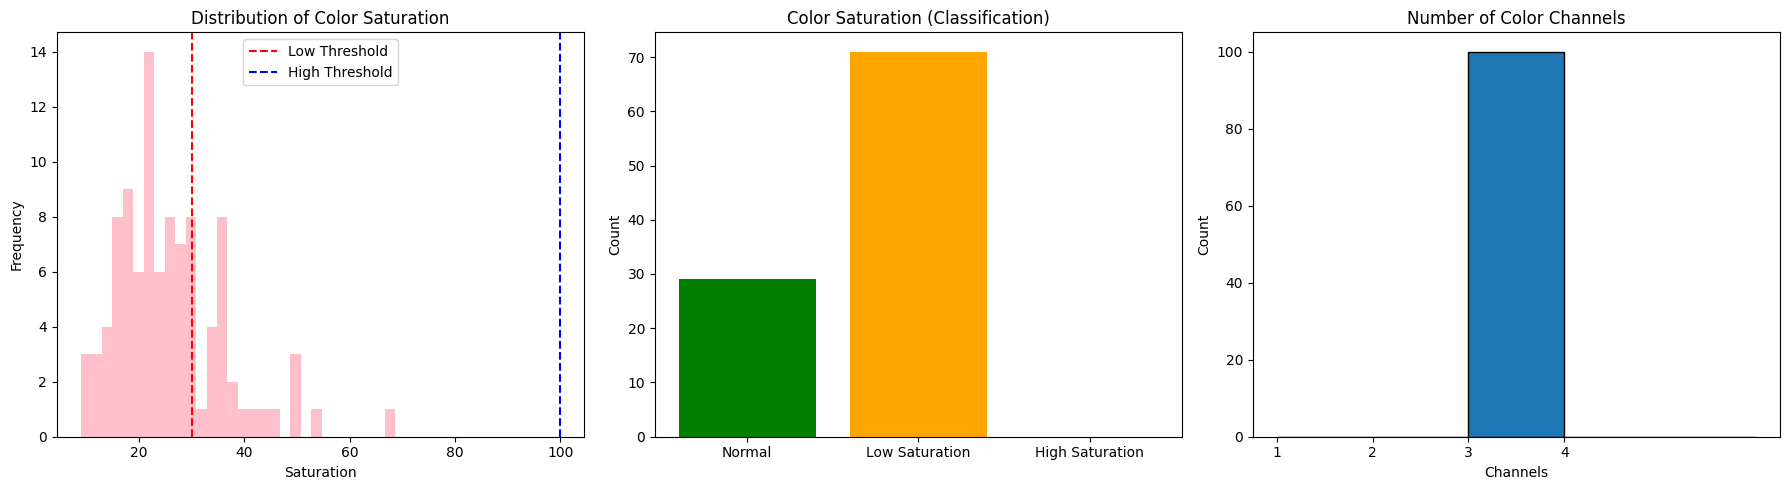

In [37]:
# COLOR SATURATION AND COLOR ANALYSIS
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Saturation histogram
axes[0].hist(df['saturation'], bins=30, color='pink')
axes[0].axvline(x=30, color='red', linestyle='--', label='Low Threshold')
axes[0].axvline(x=100, color='blue', linestyle='--', label='High Threshold')
axes[0].set_title('Distribution of Color Saturation')
axes[0].set_xlabel('Saturation')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Low/high saturation distribution
saturation_counts = pd.DataFrame({
    'Type': ['Normal', 'Low Saturation', 'High Saturation'],
    'Count': [
        ((df['low_saturation'] == False) & (df['high_saturation'] == False)).sum(),
        df['low_saturation'].sum(),
        df['high_saturation'].sum()
    ]
})
axes[1].bar(saturation_counts['Type'], saturation_counts['Count'], color=['green', 'orange', 'purple'])
axes[1].set_title('Color Saturation (Classification)')
axes[1].set_ylabel('Count')

# Color channels
axes[2].hist(df['num_channels'], bins=[1, 2, 3, 4, 5, 6], edgecolor='black')
axes[2].set_title('Number of Color Channels')
axes[2].set_xlabel('Channels')
axes[2].set_ylabel('Count')
axes[2].set_xticks([1, 2, 3, 4])

plt.tight_layout()
plt.show()


### **What These Saturation Charts Are Looking For**

This analysis evaluates **color quality** in images:

1. **Saturation Distribution Histogram**: Shows the spread of color intensity across our dataset. If values cluster below 30, our images are likely washed out or grayscale-like. If they cluster above 100, colors might be oversaturated and artificial-looking. A nice bell curve centered around 50-70 suggests natural, well-balanced colors. The vertical red and blue lines mark the thresholds.

2. **Low/Normal/High Classification Bar Chart**: This visualization categorizes images into three groups. If "Low Saturation" is dominant, you may need color enhancement. If "High Saturation" appears frequently, you might want to reduce it for more realistic colors. Ideally, most images should fall in the "Normal" range.

3. **Color Channels Histogram**: This reveals whether our dataset is consistent in color mode. If all bars are at 3 (RGB), our images are all color, good for rich embeddings.

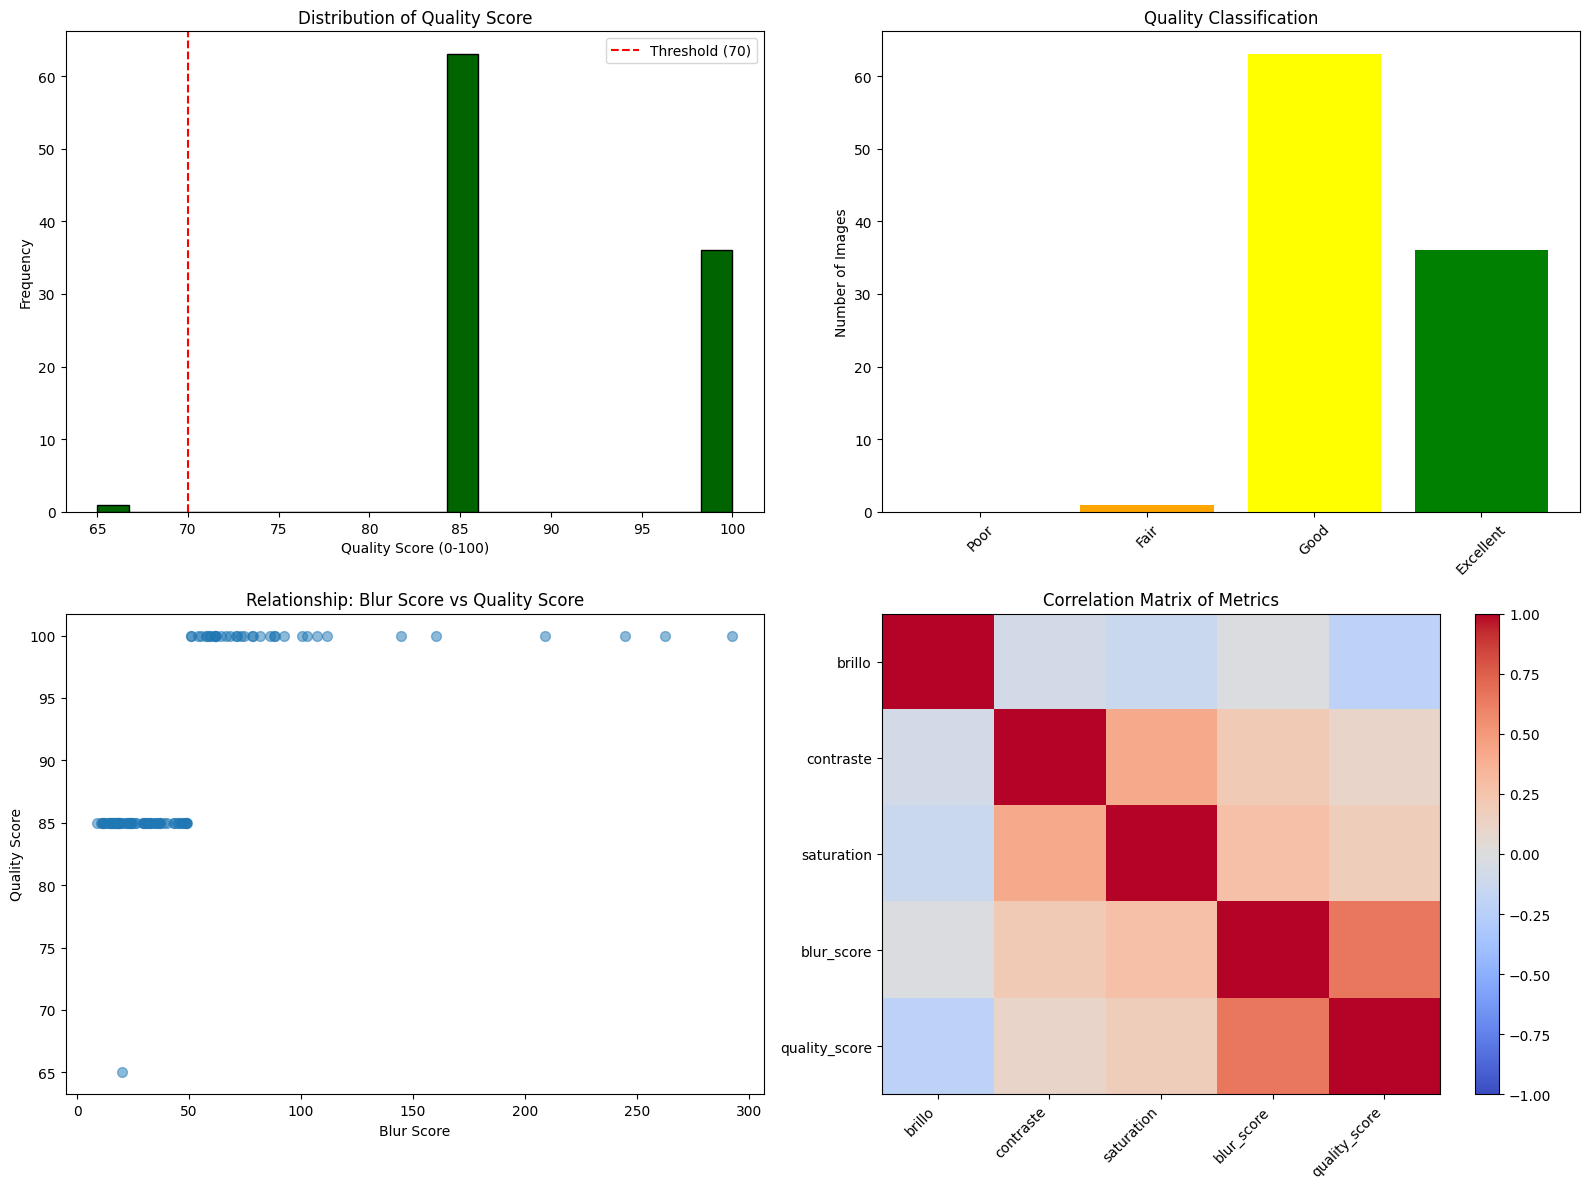

In [38]:
# QUALITY SCORE GENERAL ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Quality Score distribution
axes[0, 0].hist(df['quality_score'], bins=20, color='darkgreen', edgecolor='black')
axes[0, 0].axvline(x=70, color='red', linestyle='--', label='Threshold (70)')
axes[0, 0].set_title('Distribution of Quality Score')
axes[0, 0].set_xlabel('Quality Score (0-100)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Quality classification
quality_levels = pd.cut(df['quality_score'], bins=[0, 50, 70, 85, 100], labels=['Poor', 'Fair', 'Good', 'Excellent'])
quality_counts = quality_levels.value_counts().sort_index()
axes[0, 1].bar(quality_counts.index.astype(str), quality_counts.values, color=['red', 'orange', 'yellow', 'green'])
axes[0, 1].set_title('Quality Classification')
axes[0, 1].set_ylabel('Number of Images')
axes[0, 1].tick_params(axis='x', rotation=45)

# Blur Score vs Quality Score
axes[1, 0].scatter(df['blur_score'], df['quality_score'], alpha=0.5, s=50)
axes[1, 0].set_title('Relationship: Blur Score vs Quality Score')
axes[1, 0].set_xlabel('Blur Score')
axes[1, 0].set_ylabel('Quality Score')

# Correlación entre métricas de calidad
quality_metrics = ['brillo', 'contraste', 'saturation', 'blur_score', 'quality_score']
correlation_matrix = df[quality_metrics].corr()
im = axes[1, 1].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1, 1].set_xticks(range(len(quality_metrics)))
axes[1, 1].set_yticks(range(len(quality_metrics)))
axes[1, 1].set_xticklabels(quality_metrics, rotation=45, ha='right')
axes[1, 1].set_yticklabels(quality_metrics)
axes[1, 1].set_title('Correlation Matrix of Metrics')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()


### **What This Quality Score Analysis Is Looking For**

This is the **most important analysis** because it provides a **comprehensive quality assessment**:

1. **Quality Score Distribution**: Shows how good the images are overall (0-100). The histogram reveals whether most images cluster in high quality ranges (>70) or if quality is distributed across the spectrum.
2. **Quality Classification**: Automatically categorizes images as Poor/Fair/Good/Excellent. This bar chart quickly shows the proportion of images in each quality tier—look for most images in "Good" or "Excellent" categories.
3. **Blur vs Quality Relationship**: The scatter plot checks if blur is correlated with low quality. A downward trend indicates that blurrier images (lower blur_score) tend to have lower quality scores, confirming blur as a key quality factor.
4. **Correlation Matrix**: The heatmap identifies which metrics are related (e.g., contrast and quality). Red/positive correlations show metrics that move together, while blue/negative correlations indicate inverse relationships. This helps prioritize which improvements will have the biggest impact.


## Complete Statistical Summary

Here are all the additional metrics we have added to the quality report.


In [39]:
# RESUMEN ESTADÍSTICO COMPLETO - NUEVAS MÉTRICAS
print("="*80)
print("Complete Statistical Summary")
print("="*80 + "\n")

print("DIMENSIONS:")
print(f"   Average dimensions: {df['width'].mean():.0f}x{df['height'].mean():.0f} pixels")
print(f"   Minimum dimensions: {df['width'].min():.0f}x{df['height'].min():.0f} pixels")
print(f"   Maximum dimensions: {df['width'].max():.0f}x{df['height'].max():.0f} pixels")
print(f"   Average total pixels: {df['total_pixels'].mean():,.0f}\n")

print("ORIENTATION:")
print(f"   Squares: {df['is_square'].sum()} ({(df['is_square'].sum()/len(df)*100):.1f}%)")
print(f"   Portraits: {df['is_portrait'].sum()} ({(df['is_portrait'].sum()/len(df)*100):.1f}%)")
print(f"   Horizontals: {df['is_landscape'].sum()} ({(df['is_landscape'].sum()/len(df)*100):.1f}%)\n")

print("COLOR SATURATION:")
print(f"   Low saturation: {df['low_saturation'].sum()} ({(df['low_saturation'].sum()/len(df)*100):.1f}%)")
print(f"   High saturation: {df['high_saturation'].sum()} ({(df['high_saturation'].sum()/len(df)*100):.1f}%)")
print(f"   Average saturation: {df['saturation'].mean():.1f}\n")

print("BLUR DETECTION:")
print(f"   Images with blur: {df['blur_detected'].sum()} ({(df['blur_detected'].sum()/len(df)*100):.1f}%)")
print(f"   Average blur score: {df['blur_score'].mean():.1f}\n")

print("COMPRESSION ARTIFACTS:")
print(f"   With artifacts: {df['compression_artifacts'].sum()} ({(df['compression_artifacts'].sum()/len(df)*100):.1f}%)\n")

print("QUALITY SCORE:")
print(f"   Average score: {df['quality_score'].mean():.1f}/100")
print(f"   Minimum score: {df['quality_score'].min():.1f}/100")
print(f"   Maximum score: {df['quality_score'].max():.1f}/100")
quality_levels = pd.cut(df['quality_score'], bins=[0, 50, 70, 85, 100], labels=['Poor', 'Fair', 'Good', 'Excellent'])
for level in ['Poor', 'Fair', 'Good', 'Excellent']:
    count = (quality_levels == level).sum()
    print(f"   {level}: {count} imágenes ({(count/len(df)*100):.1f}%)")
print("\n" + "="*80)


Complete Statistical Summary

DIMENSIONS:
   Average dimensions: 600x450 pixels
   Minimum dimensions: 600x450 pixels
   Maximum dimensions: 600x450 pixels
   Average total pixels: 270,000

ORIENTATION:
   Squares: 0 (0.0%)
   Portraits: 0 (0.0%)
   Horizontals: 100 (100.0%)

COLOR SATURATION:
   Low saturation: 71 (71.0%)
   High saturation: 0 (0.0%)
   Average saturation: 25.8

BLUR DETECTION:
   Images with blur: 64 (64.0%)
   Average blur score: 52.4

COMPRESSION ARTIFACTS:
   With artifacts: 26 (26.0%)

QUALITY SCORE:
   Average score: 90.2/100
   Minimum score: 65.0/100
   Maximum score: 100.0/100
   Poor: 0 imágenes (0.0%)
   Fair: 1 imágenes (1.0%)
   Good: 63 imágenes (63.0%)
   Excellent: 36 imágenes (36.0%)



Finally, we can observe which data would require additional processing. Nevertheless, all images, regardless of whether they have a proper format or not, will go through the entire pipeline to ensure that the necessary procedures are applied.

This approach guarantees minimum quality standards in the final image outputs, providing a reliable foundation for subsequent operations in later stages, such as the exploitation layer.

------------------------------------------------------------------------------------------------------------------
---
---
------------------------------------------------------------------------------------------------------------------